## Downloading and extracting the Fashionpedia dataset

In [ ]:
# This creates a git filter that strips the notebook output when committing
!git config filter.strip-notebook-output.clean 'jupyter nbconvert --ClearOutputPreprocessor.enabled=True --to=notebook --stdin --stdout --log-level=ERROR'

# Download dataset (4 GB)
!mkdir fashionpedia
!mkdir fashionpedia/img

!curl https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip -o fashionpedia/train.zip
!unzip fashionpedia/train.zip -d fashionpedia/img
!rm fashionpedia/train.zip

!curl https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json -o fashionpedia/attributes.json

## Preprocess data
### Load data

In [1]:
%load_ext autoreload
%autoreload 2
import lib.fashionpedia_type as fpt
import lib.utils as utils

att = utils.get_fashionpedia_data()

loading data


### Preprocessing functions

73594


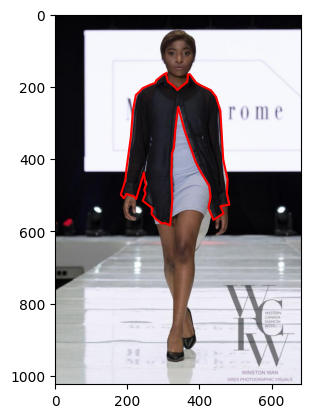

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_segmentation(annotation: fpt.Annotation):
    file_name = utils.get_by_id('images', annotation['image_id'])['file_name']
    img = mpimg.imread(f'fashionpedia/img/{file_name}')
    plt.imshow(img)

    seg = annotation['segmentation'][0]
    xs = seg[::2]
    ys = seg[1::2]
    plt.plot(xs, ys, c='red')

    plt.show()

test = utils.get_by_id('annotations', 11)
print(test['area'])
show_segmentation(test)
        

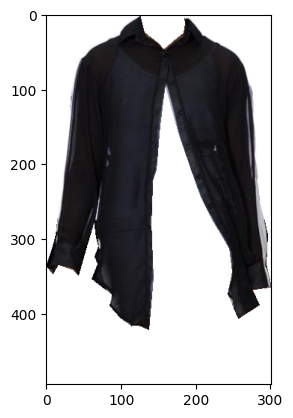

In [5]:
from PIL import Image, ImageDraw

def crop_segmentation(annotation: fpt.Annotation):
    file_name = utils.get_by_id('images', annotation['image_id'])['file_name']
    img = Image.open(f'fashionpedia/img/{file_name}').convert('RGB')

    # make segmentation mask
    mask = Image.new('1', img.size, 1)

    seg = annotation['segmentation'][0]
    points = list(zip(*(iter(seg),) * 2))

    ImageDraw.Draw(mask).polygon(points, outline=0, fill=0)
    
    # Set all but masked area white
    img.paste((256, 256, 256), mask)
    
    # crop to bounding box
    x, y, width, height = map(int, annotation['bbox'])
    cropped_image = img.crop((x, y, x + width, y + height))

    return cropped_image

test = utils.get_by_id('annotations', 11)
plt.imshow(crop_segmentation(test))
plt.show()

In [6]:
from torchvision import transforms

def resize(img):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])

    return transform(img)

### Sample data from original dataset

In [7]:
# Dataset sampling conditions
SUPERCATEGORY = 'upperbody'
DATASET_SIZE = 5000
MIN_GARMENT_AREA_RATIO = 0.25

selected_cat = [cat for cat in att['categories'] if cat['supercategory'] == SUPERCATEGORY]
selected_cat_ids = [cat['id'] for cat in selected_cat]

print("Selected categories:", *[cat['name'] for cat in selected_cat], sep='\n')

Selected categories:
shirt, blouse
top, t-shirt, sweatshirt
sweater
cardigan
jacket
vest


In [11]:
import numpy as np

# select 32 most frequent attributes
attribute_ids = [att_id for a in att['annotations'] if a['category_id'] in selected_cat_ids for att_id in a['attribute_ids']]
attribute_freqs = np.unique(attribute_ids, return_counts=True)
selected_att_ids, _ = list(zip(*sorted(zip(*attribute_freqs), key=lambda i: i[1], reverse=True)[:32]))
sorted_selected_att_ids = sorted(selected_att_ids)

print("Most frequent attributes:", *[utils.get_by_id('attributes', att_id)['name'] for att_id in selected_att_ids], sep='\n')

Most frequent attributes:
symmetrical
no non-textile material
plain (pattern)
no special manufacturing technique
above-the-hip (length)
regular (fit)
no waistline
single breasted
hip (length)
normal waist
tight (fit)
classic (t-shirt)
lining
printed
blazer
loose (fit)
zip-up
high waist
tank (top)
stripe
letters, numbers
micro (length)
plastic
check
crop (top)
biker (jacket)
camisole
floral
metal
applique(a)
mini (length)
gathering


In [12]:
import torch
from tqdm.autonotebook import tqdm

dataset = []
with tqdm(total=DATASET_SIZE) as pbar:
    for ann in att['annotations']:
        if not ann['category_id'] in selected_cat_ids:
            continue

        if type(ann['segmentation']) != list:
            # skip images with RLE segmentation masks
            continue

        img_data = utils.get_by_id('images', ann['image_id'])
        img_area = img_data['height'] * img_data['width']

        if ann['area'] / img_area < MIN_GARMENT_AREA_RATIO:
            continue

        # Crop, set to tensor and resize image
        img = crop_segmentation(ann)
        img = resize(img)
        
        dataset.append({
                'fn': img_data['file_name'],
                'ann_id': ann['id'],
                'img': img,
                'cat': ann['category_id'],
                'atts': ann['attribute_ids'],
            })
        pbar.update()
        
        if len(dataset) >= DATASET_SIZE:
            break

C:\Users\gijsa\AppData\Local\Temp\ipykernel_20012\3315765190.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/5000 [00:00<?, ?it/s]

C:\Users\gijsa\AppData\Roaming\Python\Python310\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
def normalize_dataset(data):
	# Transform list to a Tensor
	images = torch.stack([d['img'] for d in data])

	# Create normalization transformation
	means = torch.mean(images, dim = [0,2,3])
	stds = torch.std(images, dim = [0,2,3])
	normalize = transforms.Normalize(mean=means, std=stds, inplace=True)

	# Normalize the images
	for d in tqdm(data):
		normalize(d['img'])

	return means, stds


means, stds = normalize_dataset(dataset)
plt.imshow(dataset[2]['img'].permute(1, 2, 0))

## Save dataset

In [ ]:
import torch
import json

# save dataset
with open("fashionpedia/processed_dataset.pt", "wb") as file:
    torch.save({"dataset": dataset, "means": means, "stds": stds}, file)

with open("fashionpedia/selected_attributes.json", "w") as file:
    selected_atts = {int(i): utils.get_by_id('attributes', i)['name'] for i in selected_att_ids}

    json.dump(selected_atts, file, indent=1, sort_keys=True)

### Get image, categories and attributes from the dataset for diffusion experiments

Categories: top, t-shirt, sweatshirt, Attributes: polo (shirt), no special manufacturing technique, above-the-hip (length), plain (pattern), no non-textile material, regular (fit), symmetrical, no waistline


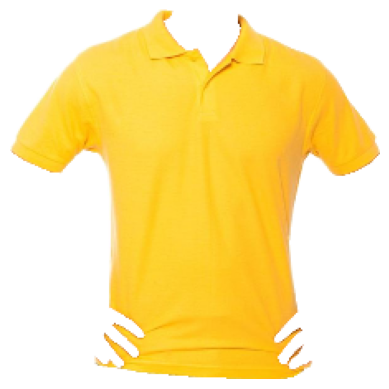

Categories: shirt, blouse, Attributes: no special manufacturing technique, normal waist, no non-textile material, regular (fit), above-the-knee (length), single breasted, floral, symmetrical


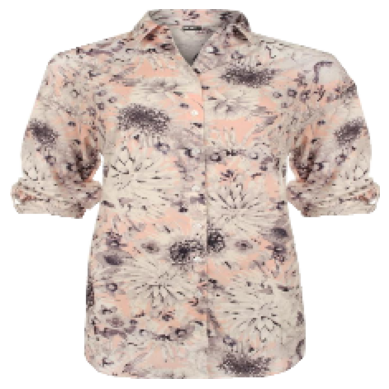

In [33]:
def get_image_and_attributes(img):

    cat_names = att['categories'][img['cat']]['name']
    att_names = ', '.join([att_['name']  for attri_id in img['atts'] for att_ in att['attributes'] if att_['id'] == attri_id])
	
    prompt = f'Categories: {cat_names}, Attributes: {att_names}'

    print(prompt)
    
    plt.imshow(img['img'].permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
get_image_and_attributes(dataset[944])
get_image_and_attributes(dataset[98])